In [79]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import torch
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

from torch import optim

from pathlib import Path
from PIL import Image, ImageFilter

In [80]:
mirror_path = Path('/kaggle/input/calibration-params/mirror1200.jpg')
mirror = Image.open(mirror_path).convert('L')

mirror = mirror.filter(ImageFilter.MedianFilter(size = 3))
mirror = mirror.filter(ImageFilter.GaussianBlur(radius = 3)) 

newsize = mirror.size[0] // 2, mirror.size[1] // 2
mirror = mirror.resize(newsize)

mirror = np.array(mirror, dtype='float32')

H, W = mirror.shape
print(H, W)

1273 1698


In [81]:
def draw_img(img):
    plt.imshow(img.clip(0, 255).astype('uint8'))
    plt.colorbar()
    plt.show()

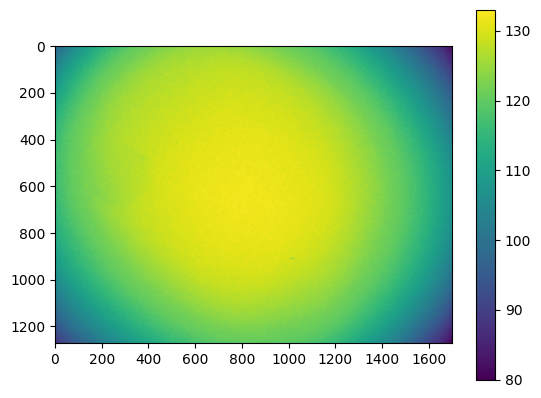

In [82]:
draw_img(mirror)

In [83]:
# H, W = 400, 600

# radiance = np.full((H, W), 150, dtype='float32')
# # gaussian
# center_x, center_y = 200, 200
# sigma = 200

# y = np.arange(H)
# x = np.arange(W)
# x_grid, y_grid = np.meshgrid(x, y)

# gaussian = np.exp(-((x_grid - center_x)**2 + (y_grid - center_y)**2) / (2 * sigma**2))
# gaussian = gaussian / np.max(gaussian)  # Нормировка в диапазон (0, 1)
# gaussian = gaussian.astype('float32')

# irradiance = gaussian * radiance

# # draw_img(irradiance)

# # corrected = gaussian.mean() * irradiance / gaussian
# # draw_img(corrected)

In [84]:
def _warp_img(img, tr, panorama_size):
    return cv2.warpPerspective(
        img.astype('float32'),
        tr,
        panorama_size,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0.0,
        flags=cv2.INTER_LINEAR
    )

def _warp_collage(images, transforms, panorama_size):
    w, h = panorama_size
    panorama = np.zeros((h, w), dtype='float32')
    for img, tr in zip(images, transforms):
        panorama = cv2.warpPerspective(
            img.astype('float32'),
            tr,
            panorama_size,
            panorama,
            borderMode=cv2.BORDER_TRANSPARENT,
            flags=cv2.INTER_LINEAR,
        )
    return panorama

In [85]:
# H_1 = np.eye(3, dtype=np.float32)

# x_shift = W // 2
# H_2= np.array([
#     [1, 0, x_shift],
#     [0, 1, 0],
#     [0, 0, 1]
# ], dtype=np.float32)

# images = [irradiance, irradiance]
# transforms = [H_1, H_2]
# panorama_size = (W + x_shift, H)

# panorama = _warp_collage(images, transforms, panorama_size)

# # draw_img(panorama)

In [86]:
H_1 = np.eye(3, dtype=np.float32)

x_shift = W // 2
y_shift = H // 2

H_2= np.array([
    [1, 0, x_shift],
    [0, 1, 0],
    [0, 0, 1]
], dtype=np.float32)

H_3= np.array([
    [1, 0, 0],
    [0, 1, y_shift],
    [0, 0, 1]
], dtype=np.float32)

H_4= np.array([
    [1, 0, x_shift],
    [0, 1, y_shift],
    [0, 0, 1]
], dtype=np.float32)

# images = [irradiance, irradiance, irradiance, irradiance]
images = [mirror, mirror, mirror, mirror]
transforms = [H_1, H_2, H_3, H_4]
panorama_size = (W + x_shift, H + y_shift)

panorama = _warp_collage(images, transforms, panorama_size)

# draw_img(panorama)

In [87]:
class OverlapDataset(Dataset):
    def __init__(self, images, transforms, panorama_size, patch_size, min_overlap=100):
        """
        images: list of np.ndarray, each of shape (H, W), float32
        transforms: list of 3x3 homographies
        panorama_size: (width, height)
        patch_size: int
        min_overlap: minimal number of valid patch centers
        """
        self.n = len(images)
        self.images = images
        self.transforms = transforms
        self.panorama_size = panorama_size
        self.patch_size = patch_size
        self.warpeds = [_warp_img(img, tr, panorama_size) for img, tr in zip(images, transforms)]

        # warp white masks
        masks = [np.ones_like(img, dtype='float32') for img in images]
        coverages = [_warp_img(mask, tr, panorama_size) for mask, tr in zip(masks, transforms)]

        self.overlaps = []
        kernel = np.ones((self.patch_size, self.patch_size), dtype='uint8')

        for i in range(self.n):
            for j in range(i + 1, self.n):
                # intersection mask
                inter = (coverages[i] > 0) & (coverages[j] > 0)
                inter = inter.astype('uint8')

                # erosion to ensure patch fits fully inside
                eroded = cv2.erode(inter, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)

                if eroded.sum() <= min_overlap:
                    continue

                # find bounding box
                ys, xs = np.where(eroded > 0)
                y_min, y_max = ys.min(), ys.max()
                x_min, x_max = xs.min(), xs.max()

                cropped_mask = eroded[y_min:y_max+1, x_min:x_max+1]

                self.overlaps.append((i, j, x_min, y_min, cropped_mask))

        if len(self.overlaps) == 0:
            raise ValueError("No overlapping regions found among warped images.")

        print(f'Found {len(self.overlaps)} overlapping regions.')

    def __len__(self):
        return 2 ** 12  # или сколько хочешь сэмплов в датасете

    def __getitem__(self, idx):
        """
        Returns:
            i: int, index of first image
            j: int, index of second image
            (x_min, y_min): top-left coordinate of the patch in panorama
            patch_i: torch.Tensor, patch from i-th image (1, patch_size, patch_size)
            patch_j: torch.Tensor, patch from j-th image (1, patch_size, patch_size)
        """
        overlap = self.overlaps[np.random.randint(len(self.overlaps))]
        i, j, x_offset, y_offset, mask = overlap

        # pick a random pixel inside the eroded intersection mask
        ys, xs = np.where(mask > 0)
        idx = np.random.randint(len(xs))
        x_rel, y_rel = xs[idx], ys[idx]

        x_center = x_offset + x_rel
        y_center = y_offset + y_rel

        # get top-left corner of patch
        x_min = x_center - self.patch_size // 2
        y_min = y_center - self.patch_size // 2

        # extract patches
        img_i = self.warpeds[i]
        img_j = self.warpeds[j]

        patch_i = img_i[y_min:y_min+self.patch_size, x_min:x_min+self.patch_size]
        patch_j = img_j[y_min:y_min+self.patch_size, x_min:x_min+self.patch_size]

        patch_i = torch.from_numpy(patch_i).unsqueeze(0).float()  # (1, patch_size, patch_size)
        patch_j = torch.from_numpy(patch_j).unsqueeze(0).float()

        return {
            'i': i,
            'j': j,
            'x_min': x_min,
            'y_min': y_min,
            'patch_i': patch_i,
            'patch_j': patch_j,
        }


In [88]:
patch_size = 64
batch_size = 8
dataset = OverlapDataset(images, transforms, panorama_size, patch_size=patch_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Found 6 overlapping regions.


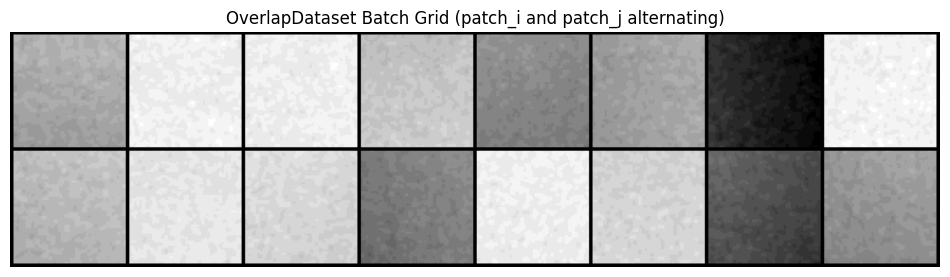

In [89]:
batch = next(iter(loader))

patches = []
for pi, pj in zip(batch['patch_i'], batch['patch_j']):
    patches.append(pi)
    patches.append(pj)

grid = make_grid(torch.stack(patches), nrow=8, padding=2, normalize=True)

# Display the grid
plt.figure(figsize=(12, 6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title('OverlapDataset Batch Grid (patch_i and patch_j alternating)')
plt.show()

In [90]:
def show_map(poly, label=None):
    H, W = 400, 600
    grid = poly.evaluate_on_grid(H, W).detach().cpu().numpy()
    
    plt.figure(figsize=(8, 5))
    im = plt.imshow(
        grid,
        cmap='viridis',
        origin='lower',
        extent=(0, W, 0, H)
    )
    if isinstance(label, str):
        plt.title(label)
    plt.xlabel('x')
    plt.ylabel('y')
    cb = plt.colorbar(im, label='P(x,y)')
    plt.tight_layout()
    plt.show()

def compare_map(model, img):
    with torch.no_grad():
        P_final = model.evaluate_on_grid(H, W).cpu().numpy()
        
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    if isinstance(label, str):
        fig.suptitle(label, fontsize=16)
            
    axes[0].imshow(img, cmap='viridis')
    axes[0].set_title('Target Image')
    axes[0].axis('off')

    axes[1].imshow(P_final, cmap='viridis')
    axes[1].set_title('Approximation')
    axes[1].axis('off')

    err = np.abs(P_final - img)
    im = axes[2].imshow(err, cmap='magma')
    axes[2].set_title('Absolute Error')
    axes[2].axis('off')
    cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_label('Error magnitude')

    plt.tight_layout()
    plt.show()

In [91]:
# class Polinom(nn.Module):
#     def __init__(self, degree=6):
#         super().__init__()
#         self.degree = degree

#         # Всего мономов степени до 6 включительно: (n+1)*(n+2)//2 = 28
#         self.num_coeffs = (self.degree + 1) * (self.degree + 2) // 2

#         # Коэффициенты: свободный член 1.0, остальные нормальное распределение
#         coeffs = torch.randn(self.num_coeffs) * 0.01  # небольшая дисперсия
#         coeffs[0] = 1.0  # свободный коэффициент

#         self.coeffs = nn.Parameter(coeffs)

#         # Предсчёт степеней для построения мономов
#         self.powers = []
#         for d in range(self.degree + 1):
#             for i in range(d + 1):
#                 j = d - i
#                 self.powers.append((i, j))  # (степень по x, степень по y)

#     def forward(self, x, y):
#         """
#         x, y: (N,) или (N, 1) или скаляры, нормированные в [0, 1]
#         возвращает: (N,) значения полинома
#         """
#         if not torch.is_tensor(x):
#             x = torch.tensor(x, dtype=torch.float32)
#         if not torch.is_tensor(y):
#             y = torch.tensor(y, dtype=torch.float32)

#         x = x.view(-1)
#         y = y.view(-1)

#         terms = []
#         for (px, py), coeff in zip(self.powers, self.coeffs):
#             terms.append(coeff * (x ** px) * (y ** py))
#         result = torch.stack(terms, dim=0).sum(dim=0)
#         return result

#     def evaluate_on_grid(self, H, W, device=None):
#         """
#         Быстрое вычисление полинома на сетке (H, W) с помощью einsum.
#         """
#         if device is None:
#             device = self.coeffs.device

#         y = torch.linspace(0, 1, H, device=device)
#         x = torch.linspace(0, 1, W, device=device)
#         Y, X = torch.meshgrid(y, x, indexing='ij')  # оба shape = (H, W)

#         pow_x = torch.tensor([p[0] for p in self.powers], dtype=torch.int64, device=device)  # (28,)
#         pow_y = torch.tensor([p[1] for p in self.powers], dtype=torch.int64, device=device)  # (28,)

#         # 3) расширяем для векторных операций
#         X_exp = X.unsqueeze(-1)  # (H, W, 1)
#         Y_exp = Y.unsqueeze(-1)  # (H, W, 1)
#         px = pow_x.view(1, 1, -1)  # (1, 1, 28)
#         py = pow_y.view(1, 1, -1)  # (1, 1, 28)

#         # 4) считаем все мономы сразу
#         M = (X_exp ** px) * (Y_exp ** py)  # (H, W, 28)

#         # 5) einsum: суммируем по k, умножая на коэффициенты
#         P = torch.einsum('hwk,k->hw', M, self.coeffs)

#         return P


In [92]:
class Polinom(nn.Module):
    def __init__(self, degree=6):
        super().__init__()
        self.degree = degree

        self.num_coeffs = (self.degree + 1) * (self.degree + 2) // 2
        assert self.num_coeffs > 0, "Number of coefficients must be positive."

        coeffs = torch.randn(self.num_coeffs) * 0.01
        coeffs[0] = 1.0
        self.coeffs = nn.Parameter(coeffs)

        self.powers = []
        for d in range(self.degree + 1):
            for i in range(d + 1):
                j = d - i
                self.powers.append((i, j))

        assert len(self.powers) == self.num_coeffs, "Mismatch in number of powers and coefficients."

    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float32)
        if not torch.is_tensor(y):
            y = torch.tensor(y, dtype=torch.float32)

        x = x.view(-1)
        y = y.view(-1)

        assert x.shape == y.shape, f"x and y must have the same shape, got {x.shape} and {y.shape}"
        assert torch.all((x >= 0) & (x <= 1)), "x values are not in [0, 1]"
        assert torch.all((y >= 0) & (y <= 1)), "y values are not in [0, 1]"

        terms = []
        for (px, py), coeff in zip(self.powers, self.coeffs):
            terms.append(coeff * (x ** px) * (y ** py))

        result = torch.stack(terms, dim=0).sum(dim=0)
        assert result.shape == x.shape, f"Result shape mismatch: expected {x.shape}, got {result.shape}"
        return result

    def evaluate_on_grid(self, H, W, device=None):
        if device is None:
            device = self.coeffs.device

        assert H > 0 and W > 0, f"Invalid grid size: H={H}, W={W}"

        y = torch.linspace(0, 1, H, device=device)
        x = torch.linspace(0, 1, W, device=device)
        Y, X = torch.meshgrid(y, x, indexing='ij')

        assert Y.shape == (H, W) and X.shape == (H, W), f"Meshgrid shape error: X={X.shape}, Y={Y.shape}"

        pow_x = torch.tensor([p[0] for p in self.powers], dtype=torch.int64, device=device)
        pow_y = torch.tensor([p[1] for p in self.powers], dtype=torch.int64, device=device)

        assert pow_x.shape == (self.num_coeffs,), "pow_x shape mismatch"
        assert pow_y.shape == (self.num_coeffs,), "pow_y shape mismatch"

        X_exp = X.unsqueeze(-1)
        Y_exp = Y.unsqueeze(-1)
        px = pow_x.view(1, 1, -1)
        py = pow_y.view(1, 1, -1)

        M = (X_exp ** px) * (Y_exp ** py)
        assert M.shape == (H, W, self.num_coeffs), f"M shape mismatch: got {M.shape}"

        P = torch.einsum('hwk,k->hw', M, self.coeffs)
        assert P.shape == (H, W), f"Output shape mismatch: expected ({H}, {W}), got {P.shape}"

        return P


In [93]:
class SigmoidPolinom(nn.Module):
    def __init__(self, degree=6):
        super().__init__()
        self.degree = degree

        # Всего мономов степени до 6 включительно: (n+1)*(n+2)//2 = 28
        self.num_coeffs = (self.degree + 1) * (self.degree + 2) // 2

        # Инициализация коэффициентов
        coeffs = torch.randn(self.num_coeffs) * 0.01
        coeffs[0] = 1.0  # свободный член
        self.coeffs = nn.Parameter(coeffs)

        # Степени для мономов
        self.powers = []
        for d in range(self.degree + 1):
            for i in range(d + 1):
                j = d - i
                self.powers.append((i, j))  # (степень по x, степень по y)

    def forward(self, x, y):
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float32)
        if not torch.is_tensor(y):
            y = torch.tensor(y, dtype=torch.float32)

        x = x.view(-1)
        y = y.view(-1)

        terms = []
        for (px, py), coeff in zip(self.powers, self.coeffs):
            terms.append(coeff * (x ** px) * (y ** py))
        result = torch.stack(terms, dim=0).sum(dim=0)

        return torch.sigmoid(result)  # <-- Применение сигмоиды

    def evaluate_on_grid(self, H, W, device=None):
        if device is None:
            device = self.coeffs.device

        y = torch.linspace(0, 1, H, device=device)
        x = torch.linspace(0, 1, W, device=device)
        Y, X = torch.meshgrid(y, x, indexing='ij')  # (H, W)

        pow_x = torch.tensor([p[0] for p in self.powers], dtype=torch.int64, device=device)
        pow_y = torch.tensor([p[1] for p in self.powers], dtype=torch.int64, device=device)

        X_exp = X.unsqueeze(-1)
        Y_exp = Y.unsqueeze(-1)
        px = pow_x.view(1, 1, -1)
        py = pow_y.view(1, 1, -1)

        M = (X_exp ** px) * (Y_exp ** py)  # (H, W, 28)

        P = torch.einsum('hwk,k->hw', M, self.coeffs)
        return torch.sigmoid(P)  # <-- Применение сигмоиды


In [94]:
class Gaussians(nn.Module):
    def __init__(self, num_components=5):
        super().__init__()
        self.num_components = num_components

        # Параметры гауссиан: (x, y, sigma_x, sigma_y, scale)
        # x и y — в диапазоне [0, 1], инициализируем равномерно
        self.xy = nn.Parameter(torch.rand(num_components, 2))  # (N, 2)

        # sigma_x и sigma_y > 0, используем softplus для обеспечения положительности
        self.log_sigma = nn.Parameter(torch.randn(num_components, 2))  # (N, 2)

        # scale > 0, используем softplus
        self.log_scale = nn.Parameter(torch.randn(num_components))  # (N,)

    def forward(self, x, y):
        """
        x, y: (N,) или (N, 1)
        Возвращает: (N,) — сумма значений гауссиан в точках
        """
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float32)
        if not torch.is_tensor(y):
            y = torch.tensor(y, dtype=torch.float32)

        x = x.view(-1, 1)  # (N, 1)
        y = y.view(-1, 1)  # (N, 1)

        # Распаковываем параметры
        mu = self.xy  # (C, 2)
        sigma = torch.nn.functional.softplus(self.log_sigma) + 1e-3  # (C, 2)
        scale = torch.nn.functional.softplus(self.log_scale).view(1, -1)  # (1, C)

        # Расчёт значения гауссиан
        dx = x - mu[:, 0]  # (N, C)
        dy = y - mu[:, 1]  # (N, C)
        gauss = torch.exp(
            -0.5 * ((dx / sigma[:, 0]) ** 2 + (dy / sigma[:, 1]) ** 2)
        )  # (N, C)
        result = (gauss * scale).sum(dim=1)  # (N,)
        return result

    def evaluate_on_grid(self, H, W, device=None):
        """
        Вычисляет значение суммы гауссиан на сетке размера (H, W).
        """
        if device is None:
            device = self.xy.device

        y = torch.linspace(0, 1, H, device=device)
        x = torch.linspace(0, 1, W, device=device)
        Y, X = torch.meshgrid(y, x, indexing='ij')  # (H, W)

        X_flat = X.reshape(-1)
        Y_flat = Y.reshape(-1)
        values = self.forward(X_flat, Y_flat)  # (H*W,)
        return values.view(H, W)


In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PixelMap(nn.Module):
    def __init__(self, H, W, mean=1.0, std=0.2):
        super().__init__()
        self.H = H
        self.W = W

        init_map = torch.randn(H, W) * std + mean
        self.map = nn.Parameter(init_map)

    def forward(self, x, y):
        """
        x, y: нормализованные координаты в диапазоне [0, 1], shape = (...)
        Возвращает: интерполированные значения из карты, shape = x.shape
        """
        assert isinstance(x, torch.Tensor) and isinstance(y, torch.Tensor), "x and y must be tensors"
        assert x.shape == y.shape, "x and y must have the same shape"
        assert torch.all((x >= 0) & (x <= 1)), "x must be in [0, 1]"
        assert torch.all((y >= 0) & (y <= 1)), "y must be in [0, 1]"

        # Перевод из [0, 1] → [-1, 1] для grid_sample
        x_norm = 2 * x - 1
        y_norm = 2 * y - 1

        # Grid: (1, N, 1, 2)
        grid = torch.stack((x_norm, y_norm), dim=-1).view(1, -1, 1, 2)
        map_ = self.map.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)

        # Интерполяция
        sampled = F.grid_sample(map_, grid, mode='bilinear', align_corners=True)
        return sampled.view(x.shape)

    def evaluate_on_grid(self, H=None, W=None, device=None):
        assert (H is None or H == self.H) and (W is None or W == self.W), \
            f"Requested size {(H, W)} does not match PixelMap size {(self.H, self.W)}"
        return self.map if device is None else self.map.to(device)

    def test_gradients(self):
        """
        Проверяет, текут ли градиенты через интерполяцию по нормализованным координатам.
        """
        print("🧪 Проверка градиентов через forward с нормализованными координатами...")

        x = torch.tensor([0.3], dtype=torch.float32)
        y = torch.tensor([0.6], dtype=torch.float32)

        if self.map.grad is not None:
            self.map.grad.zero_()

        output = self.forward(x, y)
        loss = output.sum()
        loss.backward()

        has_grad = self.map.grad is not None and self.map.grad.abs().sum() > 0
        print("✅ Градиенты проходят!" if has_grad else "❌ Градиенты НЕ проходят!")

        if has_grad:
            print(f"Макс. градиент: {self.map.grad.max().item():.4f}")
            print(f"Мин. градиент: {self.map.grad.min().item():.4f}")

        return has_grad


In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SigmoidPixelMap(nn.Module):
    def __init__(self, H, W, mean=0.0, std=0.2):
        """
        H, W: размеры карты (высота и ширина)
        mean, std: параметры нормального распределения для инициализации raw_map
        """
        super().__init__()
        self.H = H
        self.W = W

        init_map = torch.randn(H, W) * std + mean
        self.raw_map = nn.Parameter(init_map)

    def forward(self, x, y):
        """
        x, y: нормализованные координаты в диапазоне [0, 1], shape = (...)
        Возвращает: значения после билинейной интерполяции и применения сигмоиды, shape = x.shape
        """
        assert isinstance(x, torch.Tensor) and isinstance(y, torch.Tensor), "x and y must be tensors"
        assert x.shape == y.shape, "x and y must have the same shape"
        assert torch.all((x >= 0) & (x <= 1)), "x must be in [0, 1]"
        assert torch.all((y >= 0) & (y <= 1)), "y must be in [0, 1]"

        # Преобразуем [0, 1] → [-1, 1]
        x_norm = 2 * x - 1
        y_norm = 2 * y - 1

        grid = torch.stack((x_norm, y_norm), dim=-1).view(1, -1, 1, 2)
        map_raw = self.raw_map.unsqueeze(0).unsqueeze(0)

        # Интерполяция по "сырым" значениям
        map_sigmoid = torch.sigmoid(self.raw_map).unsqueeze(0).unsqueeze(0)
        sampled = F.grid_sample(map_sigmoid, grid, mode='bilinear', align_corners=True)
        return sampled.view(x.shape)


    def evaluate_on_grid(self, H=None, W=None, device=None):
        """
        Возвращает карту значений после применения сигмоиды
        """
        assert (H is None or H == self.H) and (W is None or W == self.W), \
            f"Requested size {(H, W)} does not match SigmoidPixelMap size {(self.H, self.W)}"
        out = torch.sigmoid(self.raw_map)
        return out if device is None else out.to(device)

    def test_gradients(self):
        """
        Проверяет, проходят ли градиенты через интерполяцию и сигмоиду.
        """
        print("🧪 Проверка градиентов SigmoidPixelMap...")

        x = torch.tensor([0.4], dtype=torch.float32)
        y = torch.tensor([0.7], dtype=torch.float32)

        if self.raw_map.grad is not None:
            self.raw_map.grad.zero_()

        out = self.forward(x, y)
        loss = out.sum()
        loss.backward()

        has_grad = self.raw_map.grad is not None and self.raw_map.grad.abs().sum() > 0
        print("✅ Градиенты проходят!" if has_grad else "❌ Градиенты НЕ проходят!")

        if has_grad:
            print(f"Макс. градиент: {self.raw_map.grad.max().item():.4f}")
            print(f"Мин. градиент: {self.raw_map.grad.min().item():.4f}")

        return has_grad


In [97]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def fit_on_image_lbfgs(img: np.ndarray,
                      model: torch.nn.Module,
                      max_iter: int = 300,
                      lr: float = 1.0,
                      device: torch.device = None,
                      label = None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    T = torch.from_numpy(img).float().to(device)
    H, W = img.shape

    model = model.to(device)
    optimizer = optim.LBFGS(
        model.parameters(),
        lr=lr,
        max_iter=1,  # внутренние итерации вручную
        line_search_fn='strong_wolfe'
    )
    scheduler = CosineAnnealingLR(optimizer, T_max=max_iter, eta_min=1e-5)  # eta_min = минимальный lr
    loss_fn = nn.MSELoss()
    loss_history = []
    lr_history = []

    def closure():
        optimizer.zero_grad()
        P = model.evaluate_on_grid(H, W)
        loss = loss_fn(P, T)
        loss.backward()
        return loss

    pbar = tqdm(range(1, max_iter + 1), desc="Optimizing", dynamic_ncols=True)
    for it in pbar:
        loss = optimizer.step(closure)
        scheduler.step()  # обновляем lr

        current_lr = scheduler.get_last_lr()[0]
        loss_value = loss.item() if isinstance(loss, torch.Tensor) else float(loss)
        
        loss_history.append(loss_value)
        lr_history.append(current_lr)

        pbar.set_postfix(loss=f"{loss_value:.6f}", lr=f"{current_lr:.6f}")

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

def fit_on_image_adam(img: np.ndarray,
                      model: torch.nn.Module,
                      iterations: int = 1000,
                      lr: float = 1,
                      device: torch.device = None,
                      label=None):
    """
    Аппроксимирует заданное изображение переданной моделью
    методом Adam. Показывает процесс оптимизации и финальные результаты.

    Параметры:
        img (np.ndarray): целевое изображение shape (H, W), float32 в [0,1]
        model (torch.nn.Module): экземпляр модели с методом evaluate_on_grid
        iterations (int): число итераций оптимизации
        lr (float): learning rate для Adam
        device (torch.device или None): 'cuda' или 'cpu'
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    T = torch.from_numpy(img).float().to(device)
    H, W = img.shape

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=iterations, eta_min=1e-5)
    loss_fn = nn.MSELoss()
    loss_history = []
    lr_history = []

    pbar = tqdm(range(1, iterations + 1), desc="Optimizing", dynamic_ncols=True)
    for it in pbar:
        optimizer.zero_grad()
        P = model.evaluate_on_grid(H, W)
        loss = loss_fn(P, T)
        loss.backward()
        optimizer.step()
        scheduler.step()  # обновляем lr

        current_lr = scheduler.get_last_lr()[0]
        loss_value = loss.item()
        loss_history.append(loss_value)
        lr_history.append(current_lr)

        pbar.set_postfix(loss=f"{loss_value:.6f}", lr=f"{current_lr:.6f}")

In [99]:
def fit_on_image(model, method, image, label):
    if method == 'lbfgs':
        fit_on_image_lbfgs(image, model, label=label + ' with lbfgs')
    elif method == 'adam':
        fit_on_image_adam(image, model, label=label + ' with adam')

In [100]:
# fit_on_image(Polinom(degree=6), 'lbfgs', irradiance, 'Polinom of 6 degree')

In [101]:
# polinom = Polinom(degree=6)
# fit_on_image(polinom, 'adam', irradiance, 'Polinom of 6 degree')

In [102]:
# fit_on_image(Gaussians(1), 'lbfgs', irradiance, '1 gaussian')

In [103]:
# gaussians = Gaussians(1)
# fit_on_image(gaussians, 'adam', irradiance, '1 gaussian')

In [104]:
# gaussian = Gaussians(2)
# fit_on_image(gaussian, 'lbfgs', irradiance, '2 gaussians')

In [105]:
# gaussians = Gaussians(5)
# fit_on_image(gaussians, 'lbfgs', irradiance, '5 gaussians')

In [106]:
# polynom_degrees = [1, 2, 3, 4, 5, 6, 8, 10] 
# for degree in polynom_degrees:
#     poly = Polinom(degree)
#     fit_on_image_lbfgs(image_with_gaussian, poly, max_iter=500, label=f"Polinom of {degree} degree")

In [107]:
# sigmoid_polynom_degrees = [1, 2, 3, 4, 5, 6, 8, 10] 
# for degree in sigmoid_polynom_degrees:
#     sigm_poly = SigmoidPolinom(degree)
#     fit_on_image_lbfgs(image_with_gaussian, sigm_poly, max_iter=500, label=f"SigmoidPolinom of {degree} degree")

In [108]:
# gaussian_num = [1, 2, 3, 4, 5, 6, 8, 10] 
# for num in gaussian_num :
#     gaussian = Gaussians(num)
#     fit_on_image_lbfgs(image_with_gaussian, gaussian, max_iter=500, label=f"{num} gaussians")

In [109]:
# pixel_map = PixelMap(H, W)
# fit_on_image_lbfgs(irradiance, pixel_map, max_iter=500, label=f"pixelmap")

In [110]:
# pixel_map = PixelMap(H, W)
# fit_on_image_adam(
#     img=irradiance,
#     model=pixel_map,
#     iterations=1000,
#     lr=1,
#     label="PixelMap Approximation"
# )

In [111]:
# sigmoid_pixel_map = SigmoidPixelMap(H, W)
# fit_on_image(sigmoid_pixel_map, 'lbfgs', irradiance, '5 gaussians')

In [112]:
# sigmoid_pixel_map = SigmoidPixelMap(H, W)
# fit_on_image(sigmoid_pixel_map, 'adam', irradiance, '5 gaussians')

In [113]:
# def apply_homography(x, y, homography):
#     """
#     Применяет обратную гомографию к координатам x, y (в пикселях),
#     возвращает нормированные координаты [0, 1]
#     """
#     shape = x.shape
    
#     # (P, P) → (P*P,)
#     flat_x = x.flatten().cpu().numpy()
#     flat_y = y.flatten().cpu().numpy()

#     ones = np.ones_like(flat_x)
#     pts = np.stack([flat_x, flat_y, ones], axis=0)  # (3, N)

#     warped = homography @ pts  # (3, N)
#     warped /= warped[2]  # делим на z


#     x_warped = torch.from_numpy(warped[0]).to(x.device).float().view(shape)
#     y_warped = torch.from_numpy(warped[1]).to(y.device).float().view(shape)


#     return x_warped.view(x.shape), y_warped.view(y.shape)


In [114]:
def apply_homography(x, y, homography):
    """
    Применяет обратную гомографию к координатам x, y (в пикселях),
    возвращает тензоры x_warped, y_warped таких же размеров, как x, y.
    """
    assert isinstance(x, torch.Tensor) and isinstance(y, torch.Tensor), "x and y must be torch tensors"
    assert x.shape == y.shape, f"x and y must have the same shape, got {x.shape} vs {y.shape}"
    assert x.ndim == 2, f"x and y must be 2D (patch grid), got {x.ndim}D"
    assert isinstance(homography, np.ndarray) and homography.shape == (3, 3), "homography must be (3, 3) numpy array"

    shape = x.shape

    flat_x = x.flatten().cpu().numpy()
    flat_y = y.flatten().cpu().numpy()
    ones = np.ones_like(flat_x)

    pts = np.stack([flat_x, flat_y, ones], axis=0)  # (3, N)
    assert pts.shape[1] == flat_x.size, f"Unexpected pts shape: {pts.shape}"

    warped = homography @ pts  # (3, N)
    assert not np.any(np.isnan(warped)), "NaNs in warped coordinates before normalization"
    assert not np.any(np.isinf(warped)), "Infs in warped coordinates before normalization"

    # denom = warped[2]
    # eps = 1e-8
    # denom_safe = np.where(np.abs(denom) < eps, eps, denom)
    # warped /= denom_safe  # делим на z

    denom = warped[2]
    assert np.all(np.abs(denom) > 1e-8), f"Invalid denominator in homography projection (min={denom.min()}, max={denom.max()})"
    warped /= denom  # делим на z


    assert not np.any(np.isnan(warped)), "NaNs in warped coordinates after normalization"
    assert not np.any(np.isinf(warped)), "Infs in warped coordinates after normalization"

    x_warped = torch.from_numpy(warped[0]).to(x.device).float().view(shape)
    y_warped = torch.from_numpy(warped[1]).to(y.device).float().view(shape)

    assert x_warped.shape == shape, "x_warped has incorrect shape"
    assert y_warped.shape == shape, "y_warped has incorrect shape"
    assert torch.isfinite(x_warped).all(), "x_warped contains non-finite values"
    assert torch.isfinite(y_warped).all(), "y_warped contains non-finite values"

    return x_warped, y_warped


In [115]:
# def fit_with_overlap(loader, model, transforms, panorama_size, iterations=1000, lr=1e-2, device=None):
#     if device is None:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     model = model.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     loss_fn = nn.MSELoss()

#     W, H = panorama_size
#     loss_history = []

#     for _ in tqdm(range(iterations), desc="Optimizing polynomial"):
#         batch = next(iter(loader))

#         m_map = model.evaluate_on_grid(H, W, device=device)
#         m_mean = m_map.mean().detach()

#         losses = []

#         for idx in range(len(batch['patch_i'])):
#             patch_i = batch['patch_i'][idx].to(device)
#             patch_j = batch['patch_j'][idx].to(device)
#             x_min = batch['x_min'][idx].item()
#             y_min = batch['y_min'][idx].item()
#             i = batch['i'][idx].item()
#             j = batch['j'][idx].item()

#             invert_transform_i = np.linalg.inv(transforms[i])
#             invert_transform_j = np.linalg.inv(transforms[j])

#             P = patch_i.shape[-1]
#             y, x = torch.meshgrid(
#                 torch.arange(P, device=device),
#                 torch.arange(P, device=device),
#                 indexing='ij'
#             )
#             x = x + x_min
#             y = y + y_min

#             x_i_orig, y_i_orig = apply_homography(x, y, invert_transform_i)
#             x_j_orig, y_j_orig = apply_homography(x, y, invert_transform_j)

#             x_i_norm = x_i_orig.float() / (W - 1)
#             y_i_norm = y_i_orig.float() / (H - 1)
#             M_i = model(x_i_norm, y_i_norm).reshape(P, P)

#             x_j_norm = x_j_orig.float() / (W - 1)
#             y_j_norm = y_j_orig.float() / (H - 1)
#             M_j = model(x_j_norm, y_j_norm).reshape(P, P)

#             I_corr_i = m_mean * patch_i.squeeze(0) / M_i
#             I_corr_j = m_mean * patch_j.squeeze(0) / M_j

#             loss = loss_fn(I_corr_i, I_corr_j)
#             losses.append(loss)

#         total_loss = torch.stack(losses).mean()
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()

#         loss_history.append(total_loss.item())

#     return loss_history


In [116]:
# from tqdm import tqdm
# import torch
# import torch.nn as nn
# import torch.optim as optim

# def fit_with_overlap(loader, model, transforms, panorama_size, iterations=1000, lr=1e-2, device=None):
#     if device is None:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     model = model.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     loss_fn = nn.MSELoss()

#     H, W = 400, 600
#     assert isinstance(W, int) and isinstance(H, int), "size must be (W, H) as integers"

#     loss_history = []

#     pbar = tqdm(range(iterations), desc="Optimizing polynomial", dynamic_ncols=True)

#     for it in pbar:
#         batch = next(iter(loader))

#         m_map = model.evaluate_on_grid(H, W, device=device)
#         # print(f"m_map: min={m_map.min().item()}, max={m_map.max().item()}")
        
#         assert m_map.shape == (H, W), f"Expected model output shape (H, W), got {m_map.shape}"
#         m_mean = m_map.mean()

#         losses = []

#         for idx in range(len(batch['patch_i'])):
#             patch_i = batch['patch_i'][idx].to(device)
#             patch_j = batch['patch_j'][idx].to(device)

#             assert patch_i.ndim == 3 and patch_i.shape[0] == 1, f"Expected patch_i shape (1, P, P), got {patch_i.shape}"
#             assert patch_j.ndim == 3 and patch_j.shape == patch_i.shape, f"patch_j shape mismatch: got {patch_j.shape}"

#             P = patch_i.shape[-1]

#             x_min = batch['x_min'][idx].item()
#             y_min = batch['y_min'][idx].item()
#             i = batch['i'][idx].item()
#             j = batch['j'][idx].item()

#             invert_transform_i = np.linalg.inv(transforms[i])
#             invert_transform_j = np.linalg.inv(transforms[j])

#             y, x = torch.meshgrid(
#                 torch.arange(P, device=device),
#                 torch.arange(P, device=device),
#                 indexing='ij'
#             )

#             x = x + x_min
#             y = y + y_min

#             x_i_orig, y_i_orig = apply_homography(x, y, invert_transform_i)
#             x_j_orig, y_j_orig = apply_homography(x, y, invert_transform_j)

#             x_i_norm = x_i_orig.float() / (W - 1)
#             y_i_norm = y_i_orig.float() / (H - 1)
#             M_i = model(x_i_norm, y_i_norm).reshape(P, P)

#             x_j_norm = x_j_orig.float() / (W - 1)
#             y_j_norm = y_j_orig.float() / (H - 1)
#             M_j = model(x_j_norm, y_j_norm).reshape(P, P)

#             eps = 1e-3
#             I_corr_i = (m_mean * patch_i.squeeze(0) + eps) / (M_i + eps)
#             I_corr_j = (m_mean * patch_j.squeeze(0) + eps) / (M_j + eps)

#             loss = loss_fn(I_corr_i, I_corr_j)
#             losses.append(loss)

#         total_loss = torch.stack(losses).mean()

#         optimizer.zero_grad()
#         total_loss.backward()

#         for name, param in model.named_parameters():
#             print(f"{name}: grad min={param.grad.min().item()}, max={param.grad.max().item()}, mean={param.grad.mean().item()}")

#         for name, param in model.named_parameters():
#             assert param.grad is not None, f"No gradient for parameter: {name}"
#             assert not torch.isnan(param.grad).any(), f"NaNs in gradient of {name}"
#             assert not torch.isinf(param.grad).any(), f"Infs in gradient of {name}"

#         optimizer.step()


#         loss_value = total_loss.item()
#         loss_history.append(loss_value)
#         pbar.set_postfix(loss=f"{loss_value:.6f}")

#     return loss_history


In [133]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

def fit_with_overlap(loader, model, transforms, size, iterations=1000, lr=1e-2, device=None, max_grad_norm=1000.0, l2_weight=1e-3):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    H, W = size
    assert isinstance(W, int) and isinstance(H, int), "size must be (W, H) as integers"

    loss_history = []

    pbar = tqdm(range(iterations), desc="Optimizing polynomial", dynamic_ncols=True)

    for it in pbar:
        batch = next(iter(loader))

        m_map = model.evaluate_on_grid(H, W, device=device)
        
        assert m_map.shape == (H, W), f"Expected model output shape (H, W), got {m_map.shape}"
        m_mean = m_map.mean()

        losses = []

        for idx in range(len(batch['patch_i'])):
            patch_i = batch['patch_i'][idx].to(device)
            patch_j = batch['patch_j'][idx].to(device)

            assert patch_i.ndim == 3 and patch_i.shape[0] == 1, f"Expected patch_i shape (1, P, P), got {patch_i.shape}"
            assert patch_j.ndim == 3 and patch_j.shape == patch_i.shape, f"patch_j shape mismatch: got {patch_j.shape}"

            P = patch_i.shape[-1]

            x_min = batch['x_min'][idx].item()
            y_min = batch['y_min'][idx].item()
            i = batch['i'][idx].item()
            j = batch['j'][idx].item()

            invert_transform_i = np.linalg.inv(transforms[i])
            invert_transform_j = np.linalg.inv(transforms[j])

            y, x = torch.meshgrid(
                torch.arange(P, device=device),
                torch.arange(P, device=device),
                indexing='ij'
            )

            x = x + x_min
            y = y + y_min

            x_i_orig, y_i_orig = apply_homography(x, y, invert_transform_i)
            x_j_orig, y_j_orig = apply_homography(x, y, invert_transform_j)

            x_i_norm = x_i_orig.float() / (W - 1)
            y_i_norm = y_i_orig.float() / (H - 1)
            M_i = model(x_i_norm, y_i_norm).reshape(P, P)

            x_j_norm = x_j_orig.float() / (W - 1)
            y_j_norm = y_j_orig.float() / (H - 1)
            M_j = model(x_j_norm, y_j_norm).reshape(P, P)

            eps = 1e-3
            I_corr_i = (m_mean * patch_i.squeeze(0) + eps) / (M_i + eps)
            I_corr_j = (m_mean * patch_j.squeeze(0) + eps) / (M_j + eps)

            loss = loss_fn(I_corr_i, I_corr_j)
            losses.append(loss)

        total_loss = torch.stack(losses).mean()

        # Добавляем L2-регуляризацию
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.sum(param ** 2)
        total_loss = total_loss + l2_weight * l2_reg

        optimizer.zero_grad()
        total_loss.backward()

        # # Печать градиентов
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f"{name}: grad min={param.grad.min().item()}, max={param.grad.max().item()}, mean={param.grad.mean().item()}")
        #     else:
        #         print(f"{name}: grad = None")

        # Gradient clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f"{name}: grad min={param.grad.min().item()}, max={param.grad.max().item()}, mean={param.grad.mean().item()}")
        #     else:
        #         print(f"{name}: grad = None")

        # Проверки после clipping
        for name, param in model.named_parameters():
            assert param.grad is not None, f"No gradient for parameter: {name}"
            assert not torch.isnan(param.grad).any(), f"NaNs in gradient of {name}"
            assert not torch.isinf(param.grad).any(), f"Infs in gradient of {name}"

        optimizer.step()

        loss_value = total_loss.item()
        loss_history.append(loss_value)
        pbar.set_postfix(loss=f"{loss_value:.6f}")

    return loss_history


In [118]:
# from tqdm import tqdm
# import torch
# import torch.nn as nn
# import torch.optim as optim

# def fit_with_overlap(loader, model, transforms, panorama_size, iterations=1000, lr=1e-1, device=None, max_grad_norm=1000.0, T_0=100, T_mult=2):
#     if device is None:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     model = model.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
    
#     # === Scheduler: CosineAnnealingWarmRestarts ===
#     scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult, eta_min=1e-5)

#     loss_fn = nn.MSELoss()

#     H, W = 400, 600
#     assert isinstance(W, int) and isinstance(H, int), "size must be (W, H) as integers"

#     loss_history = []

#     pbar = tqdm(range(iterations), desc="Optimizing polynomial", dynamic_ncols=True)

#     for it in pbar:
#         batch = next(iter(loader))

#         m_map = model.evaluate_on_grid(H, W, device=device)
        
#         assert m_map.shape == (H, W), f"Expected model output shape (H, W), got {m_map.shape}"
#         m_mean = m_map.mean()

#         losses = []

#         for idx in range(len(batch['patch_i'])):
#             patch_i = batch['patch_i'][idx].to(device)
#             patch_j = batch['patch_j'][idx].to(device)

#             assert patch_i.ndim == 3 and patch_i.shape[0] == 1, f"Expected patch_i shape (1, P, P), got {patch_i.shape}"
#             assert patch_j.ndim == 3 and patch_j.shape == patch_i.shape, f"patch_j shape mismatch: got {patch_j.shape}"

#             P = patch_i.shape[-1]

#             x_min = batch['x_min'][idx].item()
#             y_min = batch['y_min'][idx].item()
#             i = batch['i'][idx].item()
#             j = batch['j'][idx].item()

#             invert_transform_i = np.linalg.inv(transforms[i])
#             invert_transform_j = np.linalg.inv(transforms[j])

#             y, x = torch.meshgrid(
#                 torch.arange(P, device=device),
#                 torch.arange(P, device=device),
#                 indexing='ij'
#             )

#             x = x + x_min
#             y = y + y_min

#             x_i_orig, y_i_orig = apply_homography(x, y, invert_transform_i)
#             x_j_orig, y_j_orig = apply_homography(x, y, invert_transform_j)

#             x_i_norm = x_i_orig.float() / (W - 1)
#             y_i_norm = y_i_orig.float() / (H - 1)
#             M_i = model(x_i_norm, y_i_norm).reshape(P, P)

#             x_j_norm = x_j_orig.float() / (W - 1)
#             y_j_norm = y_j_orig.float() / (H - 1)
#             M_j = model(x_j_norm, y_j_norm).reshape(P, P)

#             eps = 1e-3
#             I_corr_i = (m_mean * patch_i.squeeze(0) + eps) / (M_i + eps)
#             I_corr_j = (m_mean * patch_j.squeeze(0) + eps) / (M_j + eps)

#             loss = loss_fn(I_corr_i, I_corr_j)
#             losses.append(loss)

#         total_loss = torch.stack(losses).mean()

#         optimizer.zero_grad()
#         total_loss.backward()

#         # Gradient clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

#         for name, param in model.named_parameters():
#             assert param.grad is not None, f"No gradient for parameter: {name}"
#             assert not torch.isnan(param.grad).any(), f"NaNs in gradient of {name}"
#             assert not torch.isinf(param.grad).any(), f"Infs in gradient of {name}"

#         optimizer.step()

#         # === scheduler step with iteration (fractional epoch) ===
#         scheduler.step(it)

#         current_lr = scheduler.get_last_lr()[0]

#         loss_value = total_loss.item()
#         loss_history.append(loss_value)

#         pbar.set_postfix(loss=f"{loss_value:.6f}", lr=f"{current_lr:.2e}")

#     return loss_history


In [119]:
# patch_size = 32
# batch_size = 32
# dataset = OverlapDataset(images, transforms, panorama_size, patch_size=patch_size)
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [120]:
# polynom_degrees = [1, 2, 3, 4, 5, 6, 8, 10] 
# for degree in polynom_degrees:
#     poly = Polinom(degree)
#     fit_with_overlap(loader, poly, transforms, panorama_size)
#     show_map(poly, label=f'Polinom of {degree} degree')
    

In [121]:
# polynom_degrees = [1, 2, 3, 4, 5, 6, 8, 10] 
# for degree in polynom_degrees:
#     sigmoid_poly = SigmoidPolinom(degree)
#     fit_with_overlap(loader, sigmoid_poly, transforms, panorama_size)
#     show_map(sigmoid_poly, label=f'Sigmoid + polinom of {degree} degree')
    

In [122]:
# pixel_map = PixelMap(H, W)
# show_map(pixel_map, label=f'initial')
# fit_with_overlap(loader, pixel_map, transforms, panorama_size)
# show_map(pixel_map, label=f'pixel_map')

In [123]:
# sigmoid_pixel_map = SigmoidPixelMap(H, W)
# show_map(sigmoid_pixel_map, label=f'initial')
# fit_with_overlap(loader, sigmoid_pixel_map, transforms, panorama_size)
# show_map(sigmoid_pixel_map, label=f'sigmoid_pixel_map')


In [124]:
# # num_gaussians = [1, 2, 3, 4, 5, 6, 8, 10] 
# num_gaussians = [6] 
# for num in num_gaussians:
#     gaussian = Gaussians(num)
#     fit_with_overlap(loader, gaussian, transforms, panorama_size)
#     show_map(gaussian, label=f'{num} gaussians')    

In [125]:
# # polynom_degrees = [1, 2, 3, 4, 5, 6, 8, 10] 
# polynom_degrees = [ 4, 5, 6,] 
# for degree in polynom_degrees:
#     poly = Polinom(degree)
#     fit_with_overlap(loader, poly, transforms, panorama_size)
#     show_map(poly, label=f'Polinom of {degree} degree')

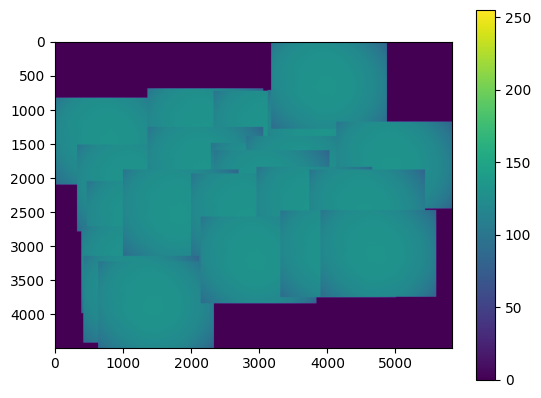

In [141]:
def draw_img(img):
    plt.imshow(img.clip(0, 255).astype('uint8'), vmin=0, vmax=255)
    plt.colorbar()
    plt.show()

# Параметры
rows, cols = 5, 5
x_shift = W // 2
y_shift = H // 2
shift_noise = 500

transforms = []
images = []

# Создаём гомографии с рандомными сдвигами
for i in range(rows):
    for j in range(cols):
        dx = j * x_shift + np.random.randint(-shift_noise, shift_noise + 1)
        dy = i * y_shift + np.random.randint(-shift_noise, shift_noise + 1)

        H_ij = np.array([
            [1, 0, dx],
            [0, 1, dy],
            [0, 0, 1]
        ], dtype=np.float32)

        transforms.append(H_ij)
        # images.append(irradiance)
        images.append(mirror)

# Функция нахождения трансляции и размера панорамы
def find_translation_and_panorama_size(sizes, transformations):
    x_coords = []
    y_coords = []
    for size, H in zip(sizes, transformations):
        corners = np.array([
            [0, 0, 1],
            [0, size[1], 1],
            [size[0], 0, 1],
            [size[0], size[1], 1]
        ])
        new_corners = H @ corners.T

        new_corners /= new_corners[2]
        x_coords += new_corners[0].tolist()
        y_coords += new_corners[1].tolist()

    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)

    T = np.array([[1, 0, -x_min],
                  [0, 1, -y_min],
                  [0, 0, 1]])

    panorama_size = (int(np.ceil(x_max - x_min)), int(np.ceil(y_max - y_min)))
    return T, panorama_size

# Все картинки одного размера
sizes = [(W, H)] * len(images)

# Считаем трансляцию и размер
T, panorama_size = find_translation_and_panorama_size(sizes, transforms)

# Применяем трансляцию к каждой гомографии
transforms = [T @ H for H in transforms]

# Склеиваем
panorama = _warp_collage(images, transforms, panorama_size)

draw_img(panorama)
# del panorama

In [134]:
patch_size = 32
batch_size = 32
dataset = OverlapDataset(images, transforms, panorama_size, patch_size=patch_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

Found 98 overlapping regions.


In [135]:
gaussian = Gaussians(6)

In [136]:
%%time
fit_with_overlap(loader, gaussian, transforms, (H, W), lr=1e-2)
fit_with_overlap(loader, gaussian, transforms, (H, W), lr=1e-2)
fit_with_overlap(loader, gaussian, transforms, (H, W), lr=1e-2)
fit_with_overlap(loader, gaussian, transforms, (H, W), lr=1e-3)
fit_with_overlap(loader, gaussian, transforms, (H, W), lr=1e-3)
fit_with_overlap(loader, gaussian, transforms, (H, W), lr=1e-3)

;

Optimizing polynomial: 100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s, loss=1.272835]

CPU times: user 25min 55s, sys: 4.61 s, total: 26min
Wall time: 25min 57s


''

In [ ]:
fit_with_overlap(loader, gaussian, transforms, (H, W), lr=1e-4)
fit_with_overlap(loader, gaussian, transforms, (H, W), lr=1e-4)

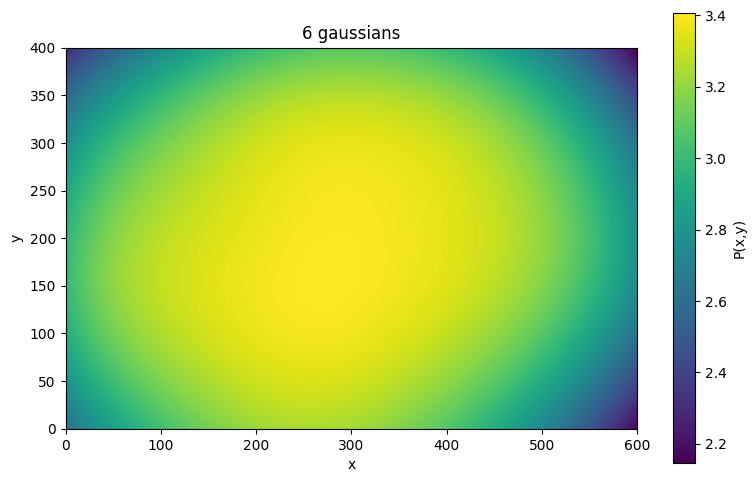

In [137]:
show_map(gaussian, label=f'{6} gaussians')  


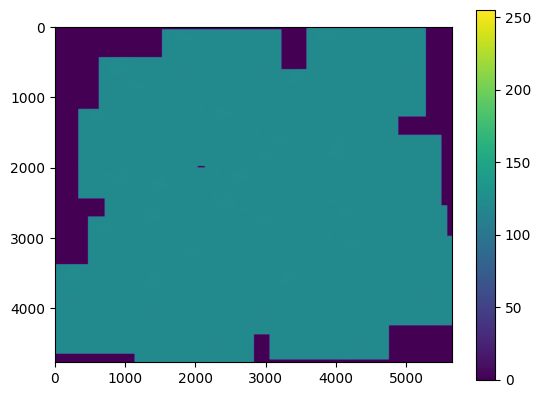

In [139]:
def FFC(image, lum_map, eps=1e-3):
    lum_map_mean = lum_map.mean()
    corrected_image = (lum_map_mean * image) / (lum_map + eps)
    return corrected_image

H, W = images[0].shape
lum_map = gaussian.evaluate_on_grid(H, W).cpu().detach().numpy()

corr_images = [FFC(img, lum_map) for img in images]


def draw_img(img):
    plt.imshow(img.clip(0, 255).astype('uint8'), vmin=0, vmax=255)
    plt.colorbar()
    plt.show()
    
corr_panorama = _warp_collage(corr_images, transforms, panorama_size)
draw_img(corr_panorama)

In [132]:
np.array(dataset.warpeds).nbytes // 1024 ** 2

2569

In [140]:
corrected_panorama_img = Image.fromarray(corr_panorama.astype('uint8'))
corrected_panorama_img.save('corrected_panorama.jpg', quality=95)

In [142]:
panorama_img = Image.fromarray(panorama.astype('uint8'))
panorama_img.save('panorama.jpg', quality=95)